# Gradient descent Magnetometer bias and offset calibration
## Background
There is a few algorithms and examples available for compensating magnetometer measurements to get rid of the biases inherent to most magnetometers. 
The algorithms I have seen are based around the idea of finding the maximum reading for each axis and using these values to compensate the bias and offset. 
This works to some extent, but there is a few drawbacks which I have struggled with in my past projects.
1. To find the maximums you have to turn the magnetometer so that the magnetic field is aligned perfectly with the axis
1. There is a manual step, where you configure the biases and offsets
1. If the errors are not completely static, there is a need for recalibrating
1. If there are outliers in the gathered data this can completely mess up the calibration
1. Calibration is difficult to do manually on an embedded system with a limited UI

When I studied neural networks, I thought that this might be an interesting model system to apply some machine learning on. 
The idea being that we want to learn the correct weights for compensating for the biases and offsets. 
The proposed solution is in essence a neural network with one layer and a linear activation function and the loss function is defined as the error in the magnitude of the magnetic field vector.
It is however easier to describe the problem as a simple optimization problem which we solve using gradient descent.

## Problem statement
The idea is to use a gradient descent to learn the soft iron and hard iron biases of a magnetometer from measured data. We assume that the measured magnetic field vector components $x_i$ are related to the magnetic field vector as $$ m_i = a_i x_i+ b_i$$ 
where $m_i$ is the normalized magnetic field vector component and the $a_i$, and $b_i$ unknown coefficients are due to the soft and hard iron biases respectively. 
The sensor will measure $\vec M$, which is proportional ti $\vec m$, but has a magnitude reflecting the local magnetic field strength.
We are not interested in magnitude of $\vec M$, but care about the direction or the normalized vector $\vec m = \frac{\vec M}{ 
|\vec M|}$. 
We will handle this implicitly as the normalization is embedded in the weights.

What we would like to do is learn the function which gives the $m_i$ components from the measured $x_i$:s. 

## Defining a loss function

The physical situation demands that the $\vec m$ should be constant in magnitude whatever we do to the system, we will only rotate the vector in space. 
Note that the magnitude $|\vec x|$ is not constant and this is why we expect this to work.

We should thus be able to use a loss function of the form 
$$L=(|\vec m|-1)^2$$

There might be situations where there are (local) external magnetic fields and thus $\vec m$ is depends on the position in space. 
We shall omit this possibility.

## Back propagating

Given our model and the loss function above, we are now interested in calculating the gradient of the loss with respect to the different weights in the model. In total we have six weights in the two vectors $\vec a$ and $\vec b$.

Lets start by calculating some intermediate results
$$\frac{dL}{d m_i} = 2\left(1-\frac{1}{|m|}\right) m_i$$

$$\frac{\partial m_i}{\partial a_j}=x_i \delta_{ij}$$

$$\frac{\partial m_i}{\partial b_j}=\delta_{ij}$$
which we can now use to calculate the gradient descent step with step size $\eta$ as
$$a_i=a_i-\eta \frac{\partial L}{\partial a_i} =a_i-\eta \cdot 2 \left(1-\frac{1}{|m|}\right) m_i x_i $$
and
$$b_i=b_i-\eta \cdot 2 \left(1-\frac{1}{|m|}\right) m_i $$.

And there we have it. 
This is a pretty straight forward an light weight algorithm for finding the weights.
There is only one parameter $\eta$ which we have to choose. 
Setting it too large might cause the solution to diverge or oscillate. 
Setting it too small will make the learning slow and it will take a long time before we learn the perturbations.
There should not be any issues with running this in real time on a microcontroller.


## Generating training data

To develop and validate the proposed solution, we will generate some data synthetically and train the data on this data. We can then compare the resulting model to the actual data as we know the correct $\vec m$ which we will distort for training purposes. 

When this works, we should try to use some actual measurements to test out the solution.

In [1]:
import numpy as np
import quaternion
import random
data_length = 5000
random.seed(0)

# The absolute length is just a scaling of little significane. Experimental magnitud around 80 using MPU9050
M_norm=80.
#a is the scaling due to soft iron errors
a=np.array([1.1,1.12,1.14])
#b is the offset due to hard iron errors
b=np.array([20,30,40])


M=np.quaternion(0,M_norm,0,0)
qs = quaternion.as_quat_array(np.random.rand(data_length, 4))
#X is a uniform distribution of measurements
X=[]
#X_ass is assymetric with a
X_ass=[]
x_prev=M
for q in qs:
    # For each random quaternion, use it to rotate M and get a new M with random orientation
    q=q.normalized()
    x=q*x_prev*q.conjugate()
    x_prev=x
    # To generate assymetric data, allways start with the (0,M_norm,0,0) vector
    x_a=q*M*q.conjugate()
    
    #Create the vector from the imaginary part of the quaternion
    X.append(np.array([x.x,x.y,x.z]))
    X_ass.append(np.array([x_a.x,x_a.y,x_a.z]))
X_ass=np.array(X_ass)
X=np.array(X)
assert X.shape[0]==data_length, "Dimension check."
assert X.shape[1]==3, "Dimension check."
cg_offset=np.sum(np.sum(np.mean(X,axis=0)**2))
assert cg_offset<0.1*M_norm, "Center of gravity check, offset: {}".format(cg_offset)
#Now we have data_length random vectors to play with.

#Generate expected M values
M=X

#Apply perturbation scalings and biases
for row_i in range(X.shape[0]):
    X[row_i]=X[row_i]*a+b    
    X_ass[row_i]=X_ass[row_i]*a+b    



## Visualization of data sets
At this point it is worth to define some helper classes to aid visualization of the data sets. 
This will be useful to validate the model later on.

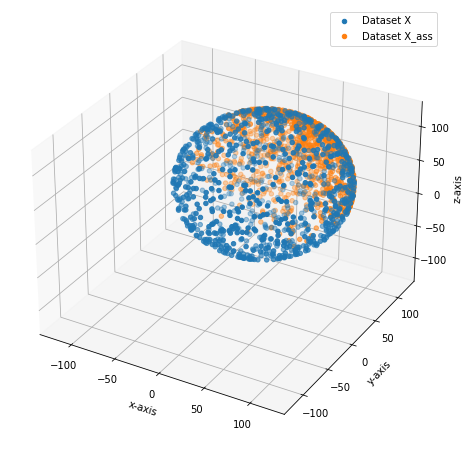

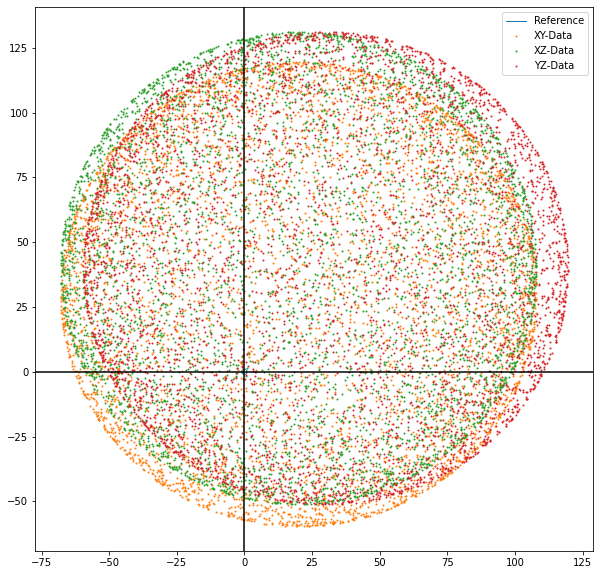

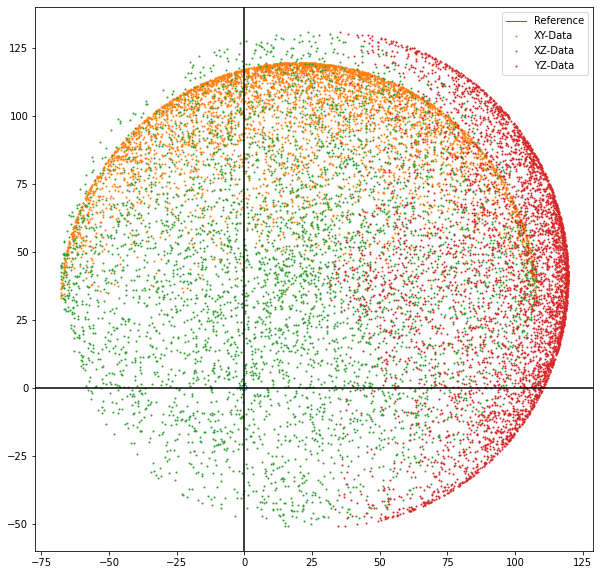

In [2]:
import matplotlib.pyplot as plt
    
class visualizer3D():
    def __init__(self):
        self.datasets=[]
        self.labels=[]
        self.point_count=1000
        self.axis_labels=["x-axis","y-axis","z-axis"]
        pass
    def add(self,x,label):
        assert x.shape[0]==3, "Data shape invalid shape: {}.".format(x.shape[0])
        self.datasets.append(x)
        self.labels.append(label)
        pass
    def show_3D(self):
        assert(len(self.datasets)>=1)
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')            
        ax.set_xlabel(self.axis_labels[0])
        ax.set_ylabel(self.axis_labels[1])
        ax.set_zlabel(self.axis_labels[2])
        i=0
        for data in self.datasets:
            ax.scatter(data[0,:self.point_count], data[1,:self.point_count], data[2,:self.point_count], marker='o', label=self.labels[i])
            ax.set_aspect("auto")
            i+=1
        
        scale=max([max([max(data[0]),max(data[1]),max(data[2])]) for data in self.datasets])
        ax.set_xlim(-scale,scale)
        ax.set_ylim(-scale,scale)
        ax.set_zlim(-scale,scale)
        plt.legend()
        plt.show()
        pass

class visualizer2D():
    def __init__(self):
        self.datasets=[]
        self.labels=[]
        self.point_count=5000
        pass
    def add(self,x,y,label):
        assert x.shape[0]==x.size, "Data shape invalid shape: {}.".format(x.shape[0])
        assert y.shape[0]==y.size, "Data shape invalid shape: {}.".format(y.shape[0])
        self.datasets.append(np.vstack([x,y]).T)
        self.labels.append(label)
        pass
    def show_2D(self,draw_ref_circle=True):
        plt.figure(figsize=(10, 10))
        if draw_ref_circle:
            circle=[]
            import math
            for i in range(500):
                circle.append([math.sin(6.28*i/500),math.cos(6.28*i/500)])
            circle=np.array(circle)
            plt.plot(circle[:,0],circle[:,1],linewidth=1,markersize=0,label="Reference")
        i=0
        for data in self.datasets:
            plt.plot(data[:self.point_count,0],data[:self.point_count,1],linewidth=0,markersize=1,marker='o',label=self.labels[i])
            i+=1
        plt.legend()
        plt.axhline(y=0, color='k')
        plt.axvline(x=0, color='k')
        plt.show()
        pass


vis=visualizer3D()
vis.add(X.T,'Dataset X')
vis.add(X_ass.T,'Dataset X_ass')
vis.show_3D()
vis=visualizer2D()
vis.add(X[:,0],X[:,1],'XY-Data')
vis.add(X[:,0],X[:,2],'XZ-Data')
vis.add(X[:,1],X[:,2],'YZ-Data')
vis.show_2D()
vis=visualizer2D()
vis.add(X_ass[:,0],X_ass[:,1],'XY-Data')
vis.add(X_ass[:,0],X_ass[:,2],'XZ-Data')
vis.add(X_ass[:,1],X_ass[:,2],'YZ-Data')
vis.show_2D()

## Implementing the model
The model only requires a few lines of code.

In [3]:
class Simple_Model(object):
    def __init__(self,eta=1e-4,a=np.ones((3,1)),b=np.zeros((3,1))):
        self.a=a
        self.b=b
        self.eta=eta
    def update(self,x):
        if x.shape==(3,): 
            x=x.reshape(3,1)
        assert x.shape==(3,1), "x should be column vector, found shape {}".format(x.shape)
        m=self.predict(x)
        norm_m=
        
        
        assert norm_m!=0, "prediction is zero vector"
        self.a-=self.eta*2*(1-1/norm_m)*m*x
        self.b-=self.eta*2*(1-1/norm_m)*m
        
    def predict(self,x):
        if x.shape==(3,): 
            x=x.reshape(3,1)
        assert x.shape==(3,1), "x should be column vector, found shape {}".format(x.shape)
        m=self.a*x+self.b
        return m.reshape(3,1)

This model works well, but it is rather slow to find the solution when the data is not normalized. 
To improve the learning rate, we can leverage the fact that we rougly know the scaling factor.

In [4]:
class Model():
    def __init__(self,eta=1e-1,a=np.ones((3,1)),b=np.zeros((3,1)), norm=0):
        self.a=a
        self.b=b
        self.eta=eta
        self.norm_x=norm
    
    def update(self,x):
        if self.norm_x==0:
            self.norm_x=np.sqrt(np.sum(np.square(x)))
            assert self.norm_x != 0, "Input data is zero vector"
        if x.shape==(3,): 
            x=x.reshape(3,1)
        assert x.shape==(3,1), "x should be column vector, found shape {}".format(x.shape)
        m=self.predict(x)
        norm_m=np.sqrt(np.sum(np.square(m)))
        assert norm_m!=0, "prediction is zero vector"
        x_normalized=x/self.norm_x
        self.a-=self.eta*2*(1-1/norm_m)*m*x_normalized
        self.b-=self.eta*2*(1-1/norm_m)*m
            
    def predict(self,x):
        if x.shape==(3,): 
            x=x.reshape(3,1)
        assert x.shape==(3,1), "x should be column vector, found shape {}".format(x.shape)
        x_normalized=x/self.norm_x
        m=self.a*x_normalized+self.b
        return m.reshape(3,1)
    

## Training and testing
Now we have a model, some date and some utilities for visualizing the data. 
We will use the graphs to validate the model instead of trying to define some metrics.

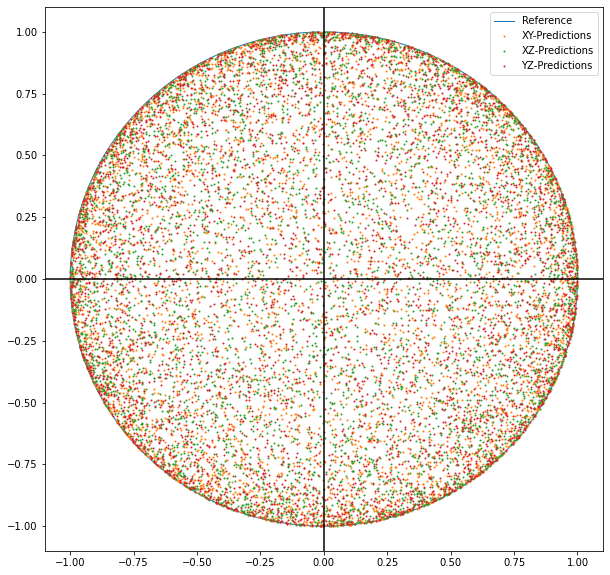

In [5]:
model=Model(eta=1e-1,a=np.ones((3,1)),b=np.zeros((3,1)))
epochs=1
for i in range(epochs):
    for data_point in X:
        model.update(data_point)

Y=np.array([])
for data_point in X:
    pred=model.predict(data_point).T
    if Y.size==0:
        Y=pred
    else:
        Y=np.vstack((Y,pred))

vis=visualizer2D()
vis.add(X[:,0],X[:,1],'XY-Data')
vis.add(X[:,0],X[:,2],'XZ-Data')
vis.add(X[:,1],X[:,2],'YZ-Data')
vis.add(Y[:,0],Y[:,1],'Predictions')
#vis.show_2D()
vis=visualizer2D()
vis.add(Y[:,0],Y[:,1],'XY-Predictions')
vis.add(Y[:,0],Y[:,2],'XZ-Predictions')
vis.add(Y[:,1],Y[:,2],'YZ-Predictions')
vis.show_2D()

## Asymetric data
One of the motivations for using this method is to alleviate the requiremetns of finding the maximas aroind each axis. The assymetric data set has no datapoints along the negative Y-axis. We will now use this data set to learn the parameters and compare with the expected results.

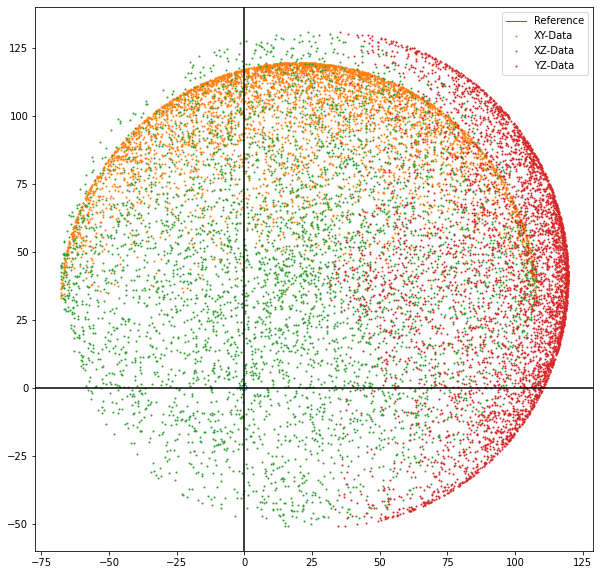

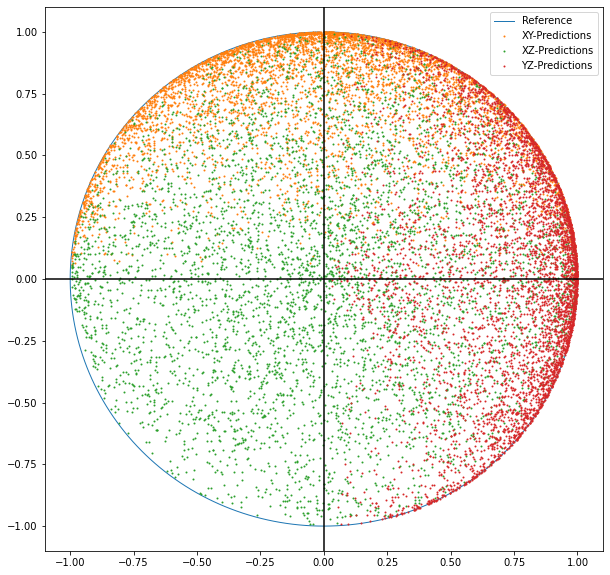

In [6]:
model=Model(eta=1e-1,a=np.ones((3,1)),b=np.zeros((3,1)))
epochs=10
for i in range(epochs):
    for data_point in X_ass:
        model.update(data_point)

Y=np.array([])
for data_point in X_ass:
    pred=model.predict(data_point).T
    if Y.size==0:
        Y=pred
    else:
        Y=np.vstack((Y,pred))

vis=visualizer2D()
vis.add(X_ass[:,0],X_ass[:,1],'XY-Data')
vis.add(X_ass[:,0],X_ass[:,2],'XZ-Data')
vis.add(X_ass[:,1],X_ass[:,2],'YZ-Data')
#vis.add(Y[:,0],Y[:,1],'Predictions')
vis.show_2D()
vis=visualizer2D()
vis.add(Y[:,0],Y[:,1],'XY-Predictions')
vis.add(Y[:,0],Y[:,2],'XZ-Predictions')
vis.add(Y[:,1],Y[:,2],'YZ-Predictions')
vis.show_2D()

As seen from the experiments, it does work. However, it requires much more training. 

## Benchmarking the heuristic normaliztion
The data is normalized using the first data point to speed up the training. To validate this and compare against the Simple_Model class we will make a quick qualification test.

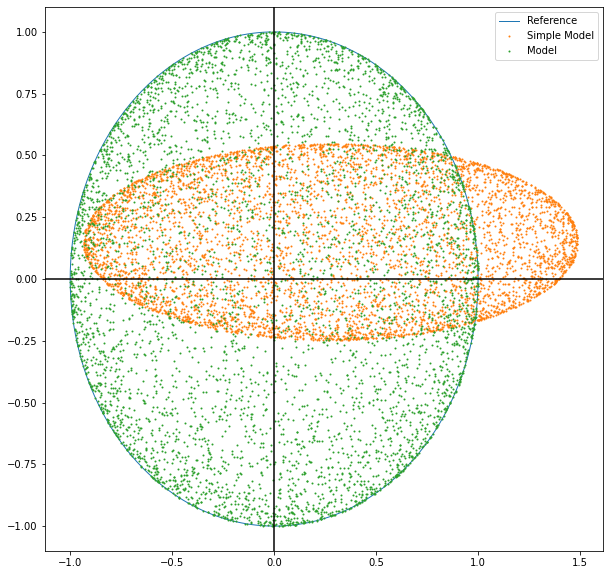

In [7]:
model=Simple_Model(eta=1e-4,a=np.ones((3,1)),b=np.zeros((3,1)))
model1=Model(eta=1e-1,a=np.ones((3,1)),b=np.zeros((3,1)))
epochs=1
for i in range(epochs):
    for data_point in X:
        model.update(data_point)
        model1.update(data_point)

Y=np.array([])
Y1=np.array([])

for data_point in X:
    pred=model.predict(data_point).T
    if Y.size==0:
        Y=pred
    else:
        Y=np.vstack((Y,pred))
    pred=model1.predict(data_point).T
    if Y1.size==0:
        Y1=pred
    else:
        Y1=np.vstack((Y1,pred))
        
vis=visualizer2D()
vis.add(Y[:,0],Y[:,1],'Simple Model')
vis.add(Y1[:,0],Y1[:,1],'Model')
vis.show_2D()

## Enter Empirical Data
At this point the model is working pretty well with syntethic generated data and it is now time to validate it with some actual empirical data before deploying to the microcontroller

In [8]:
data_set=[]
import csv
with open('mag_raw_data_long.txt', newline = '') as data_file:
    mag_data = csv.reader(data_file, delimiter='\t')
    for data_point in mag_data:
        data_set.append([float(i) for i in data_point])
    data_set=np.array(data_set)
print("Data set length: {} points".format(data_set.shape[0]))

Data set length: 1114 points


Bias: [[1.17950267 1.2093538  1.22207922]]
Bias scaled: [[0.02177953 0.02233073 0.02256571]]
Normalization: 54.156479450235686
Offset: [[-0.01615767 -0.16155351 -0.56559664]]


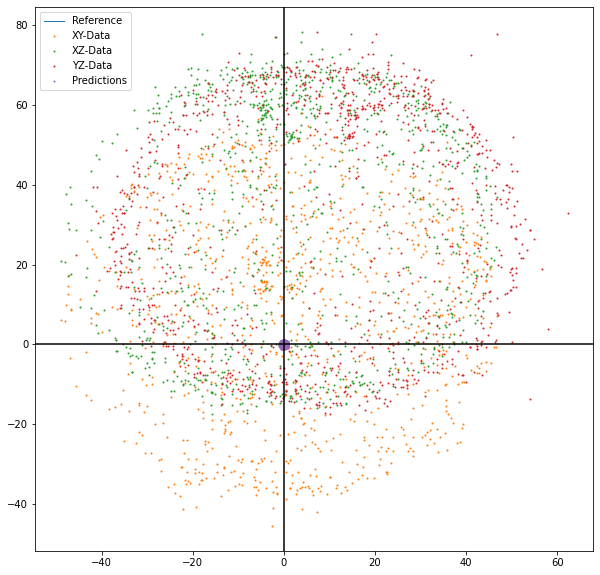

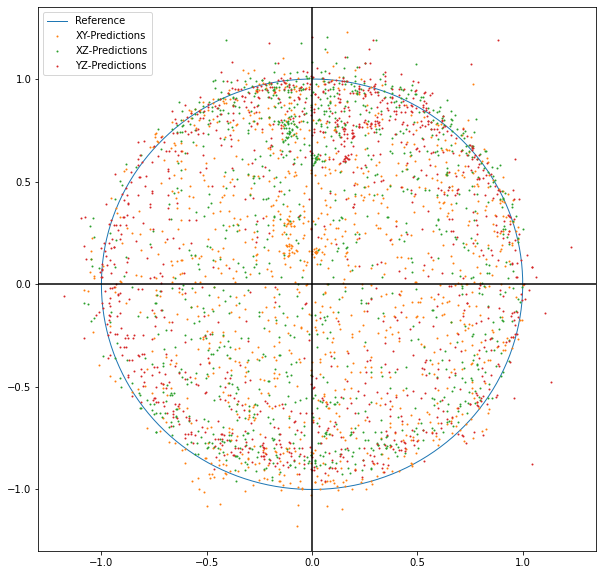

In [9]:
model=Model(eta=1e-3,a=np.ones((3,1)),b=np.zeros((3,1)))
epochs=10
for i in range(epochs):
    for data_point in data_set:
        model.update(data_point)

Y=np.array([])
for data_point in data_set:
    pred=model.predict(data_point).T
    if Y.size==0:
        Y=pred
    else:
        Y=np.vstack((Y,pred))
print("Bias: {}".format(model.a.T))
print("Bias scaled: {}".format(model.a.T/model.norm_x))
print("Normalization: {}".format(model.norm_x))
print("Offset: {}".format(model.b.T))
        
vis=visualizer2D()
vis.add(data_set[:,0],data_set[:,1],'XY-Data')
vis.add(data_set[:,0],data_set[:,2],'XZ-Data')
vis.add(data_set[:,1],data_set[:,2],'YZ-Data')
vis.add(Y[:,0],Y[:,1],'Predictions')
vis.show_2D()
vis=visualizer2D()
vis.add(Y[:,0],Y[:,1],'XY-Predictions')
vis.add(Y[:,0],Y[:,2],'XZ-Predictions')
vis.add(Y[:,1],Y[:,2],'YZ-Predictions')
vis.show_2D()

As seen from the experiments, the model seem to work decently with real life data.
There are a few obvious limiations though.
1. It requires a lot of data to learn the biases - roughly 1000 samples which takes on the order of 2 minutes to gather
1. There are some outliers in the data which probably messes with the learning 
1. Running for multiple epochs will not be feasible for the deployed model, so we will require even more data

In practice, it will be useful to save the model once learned and then continue learning to adjust and compensate for changes over time.

## Using pre-trained weights
Let's have a look at how it works out when we use the biases to pre-process the data.

In [10]:
short_data_set=[]
import csv
with open('mag_raw_data.txt', newline = '') as data_file:
    mag_data = csv.reader(data_file, delimiter='\t')
    for data_point in mag_data:
        short_data_set.append([float(i) for i in data_point])
short_data_set=np.array(short_data_set)
print("Data set length: {} points".format(short_data_set.shape[0]))

Data set length: 128 points


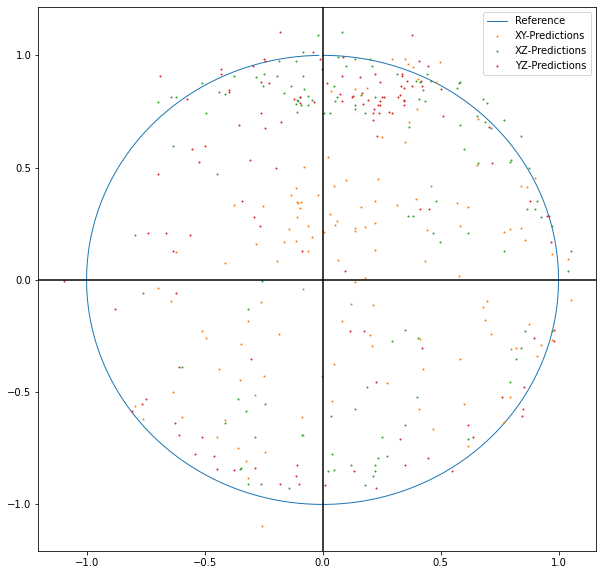

In [11]:
bias=np.array([[1.17950267, 1.2093538, 1.22207922]]).T
offset=np.array([[-0.01615767, -0.16155351, -0.56559664]]).T
normalization=54.156479450235686


model=Model(eta=1e-3,a=bias,b=offset,norm=normalization)
epochs=1
for i in range(epochs):
    for data_point in short_data_set:
        model.update(data_point)

Y=np.array([])
for data_point in short_data_set:
    pred=model.predict(data_point).T
    if Y.size==0:
        Y=pred
    else:
        Y=np.vstack((Y,pred))
        
vis=visualizer2D()
vis.add(Y[:,0],Y[:,1],'XY-Predictions')
vis.add(Y[:,0],Y[:,2],'XZ-Predictions')
vis.add(Y[:,1],Y[:,2],'YZ-Predictions')
vis.show_2D()

In [12]:
class foo():
    def __init__(self,bar=np.ones((1,1))):
        print("Created.")
        self.parameter=bar
    def increment_parameter(self):
        self.parameter+=1
    def __del__(self):
        print("Destroyed. Parameter val: {}".format(self.parameter))

In [13]:
test=foo()
test.increment_parameter()

test2=foo(np.ones((1,1)))
test2.increment_parameter()

Created.
Created.
